Text(0.5, 1.0, 'smoothed')

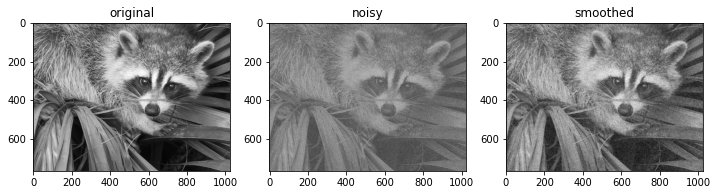

In [1]:

from scipy import misc
import jax.scipy as jsp
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Load a sample image; compute mean() to convert from RGB to grayscale.
image = jnp.array(misc.face().mean(-1))
ax[0].imshow(image, cmap="binary_r")
ax[0].set_title("original")

# Create a noisy version by adding random Gausian noise
key = random.PRNGKey(1701)
noisy_image = image + 50 * random.normal(key, image.shape)
ax[1].imshow(noisy_image, cmap="binary_r")
ax[1].set_title("noisy")

# Smooth the noisy image with a 2D Gaussian smoothing kernel.
x = jnp.linspace(-3, 3, 7)
window = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:, None])
smooth_image = jsp.signal.convolve(noisy_image, window, mode="same")
ax[2].imshow(smooth_image, cmap="binary_r")
ax[2].set_title("smoothed")

In [100]:

xs = jsp.stats.norm.pdf(x)
xt = jsp.stats.norm.pdf(x[:, jnp.newaxis])
xt

DeviceArray([[0.00443185],
             [0.05399096],
             [0.24197076],
             [0.3989423 ],
             [0.24197073],
             [0.05399096],
             [0.00443185]], dtype=float32)

In [113]:

kernel = jnp.zeros((3, 3, 3, 3), dtype=jnp.float32)
a = jnp.array([[1, 1, 0], [1, 0, -1], [0, -1, -1]])[:, [1, 2], jnp.newaxis]
a.shape

(3, 2, 1)

In [110]:

jnp.repeat(xt, 7, axis=-1) * jnp.tile(xs, (7, 1)) == window

DeviceArray([[ True,  True,  True,  True,  True,  True,  True],
             [ True,  True,  True,  True,  True,  True,  True],
             [ True,  True,  True,  True,  True,  True,  True],
             [ True,  True,  True,  True,  True,  True,  True],
             [ True,  True,  True,  True,  True,  True,  True],
             [ True,  True,  True,  True,  True,  True,  True],
             [ True,  True,  True,  True,  True,  True,  True]],            dtype=bool)

In [83]:

x = jnp.linspace(-3, 3, 7)
window = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:6, None])

(5, 7)

In [89]:

xs = jsp.stats.norm.pdf(x)
xt = jsp.stats.norm.pdf(x[:, jnp.newaxis])
xt.shape
xs

DeviceArray([0.00443185, 0.05399096, 0.24197076, 0.3989423 , 0.24197073,
             0.05399096, 0.00443185], dtype=float32)

In [2]:

import jax

a = jnp.ones((32, 20, 60))
key = jax.random.PRNGKey(42)
kernel = jax.random.normal(key, shape=(3, 60, 60))
dn = jax.lax.conv_dimension_numbers(a.shape, kernel.shape, ("NWC", "WIO", "NWC"))
dn

ConvDimensionNumbers(lhs_spec=(0, 2, 1), rhs_spec=(2, 1, 0), out_spec=(0, 2, 1))

In [7]:

def f(a, kernel):
    out = jax.lax.conv_general_dilated(a, kernel, (1,), "SAME", dimension_numbers=dn)
    return jnp.sum(out)

NameError: name 'Tuple' is not defined

In [14]:


def f(x):
    y = 3 if x.shape[-1] != 2 else 2
    if x.shape[0] == 3:
        return y * x
    else:
        return y - x


x = jnp.ones((4, 2))
jax.jit(f)(x)

DeviceArray([[1., 1.],
             [1., 1.],
             [1., 1.],
             [1., 1.]], dtype=float32)

In [31]:

def f(x):
    return jnp.all(jnp.where(x<3,True,False))

def relu(x):
    # return jnp.where(x>0,x,0)
    return jax.lax.cond(jnp.all(x>0),lambda x:x, lambda x:0.,x)

jax.jit(relu)(3.)

DeviceArray(3., dtype=float32, weak_type=True)

In [ ]:

import haiku as hk
import jax
import jax.numpy as jnp

In [101]:

@partial(jax.custom_jvp, nondiff_argnums=(1,))
def f(x,a=1):
    return x+a

@f.defjvp
def f_jvp(a,x,dx):
    x, = x
    dx, = dx
    return f(x)+1, (x+8)*dx

jax.jit(f)(2.)

DeviceArray(3., dtype=float32, weak_type=True)

In [128]:

@hk.to_module
def ff_(x):
    w = hk.get_parameter("wwx", [], init=jnp.ones)
    w *= 5
    return w*x

class mylinear(hk.Module):
    def __init__(self, out, name):
        super().__init__(name=name)
        self.w = hk.get_parameter("w", shape=[3,2], dtype=jnp.float32, init=jnp.ones)
        self.s = hk.set_state("s", jnp.zeros([]))

    def __call__(self,x):
        s = hk.get_state("s", shape=[], dtype=jnp.float32, init=jnp.ones)
        ff = [ff_() for _ in range(2)]
        t = ff[0](s)
        w = ff[1](t)
        s += f(w)
        return ff[1](s)

x = jnp.array([1.,2.])

@hk.transform_with_state
def fwd(x):
    return mylinear(2, "good")(x)

key = jax.random.PRNGKey(42)
params,s = fwd.init(key,x)

jax.grad(fwd.apply,has_aux=True)(params,rng=None,x=x,state=s)
# jax.jit(fwd.apply)(params,rng=None,x=x,state=s)

({'good': {'w': DeviceArray([[0., 0.],
                [0., 0.],
                [0., 0.]], dtype=float32)},
  'good/ff_': {'wwx': DeviceArray(0., dtype=float32)},
  'good/ff__1': {'wwx': DeviceArray(10., dtype=float32)}},
 {'good': {'s': DeviceArray(0., dtype=float32)}})

In [51]:

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np

from functools import partial
from typing import *

class GLU(hk.Module):
    def __init__(
        self,
        kernel_size = 3,
        input_repr = "NWC",
        kernel_repr = "WIO",
        output_repr = "NWC",
        output_channel = None,
        name=None,
    ):
        super().__init__(name=name)
        self.kernel_size = kernel_size
        self.input_repr = input_repr
        self.kernel_repr = kernel_repr
        self.output_repr = output_repr

        self.output_channel = output_channel

    def __call__(self,x):
        """
        x is a B*N*m where 
        B is the batch size 
        N is the sequence length and 
        m is the embedding size

        the output shape are the same
        """
        input_shape = x.shape
        output_channel = self.output_channel if self.output_channel is not None else x.shape[-1]
        kernel_shape = (self.kernel_size,x.shape[-1],output_channel,)
        dn = jax.lax.conv_dimension_numbers(
                input_shape, 
                kernel_shape, 
                (self.input_repr,self.kernel_repr,self.output_repr), 
        )
        """Init kernel"""
        stddev = 1. / jnp.sqrt(self.kernel_size)
        kernel_init = hk.initializers.TruncatedNormal(stddev=stddev)
        kernel_w = hk.get_parameter("kernel_w", shape=kernel_shape, dtype=x.dtype, init=kernel_init)
        b_w = hk.get_parameter("bias_w", shape=(output_channel,), dtype=x.dtype, init=jnp.zeros)
        kernel_e = hk.get_parameter("kernel_e", shape=kernel_shape, dtype=x.dtype, init=kernel_init)
        b_e = hk.get_parameter("bias_e", shape=(output_channel,), dtype=x.dtype, init=jnp.zeros)

        conv_w = jax.lax.conv_general_dilated(x, kernel_w, (1,), "SAME", dimension_numbers=dn) + b_w
        conv_e = jax.lax.conv_general_dilated(x, kernel_e, (1,), "SAME", dimension_numbers=dn) + b_e
        gated = jax.nn.sigmoid(conv_e)
        out = conv_w * gated
        return out

In [134]:

a = np.arange(24).reshape(2,3,4)
b = np.ones((4,3))

np.dot(b,a)

array([[[12., 15., 18., 21.],
        [48., 51., 54., 57.]],

       [[12., 15., 18., 21.],
        [48., 51., 54., 57.]],

       [[12., 15., 18., 21.],
        [48., 51., 54., 57.]],

       [[12., 15., 18., 21.],
        [48., 51., 54., 57.]]])

In [131]:

np.einsum("...k,kj->...j",a,b)

array([[[ 6.,  6.,  6.],
        [22., 22., 22.],
        [38., 38., 38.]],

       [[54., 54., 54.],
        [70., 70., 70.],
        [86., 86., 86.]]])

In [1]:

import haiku as hk
import jax
import jax.numpy as jnp
from tabnet import TabnetEncoder

@hk.transform_with_state
def fwd(x):
    tabnet = TabnetEncoder()
    return tabnet(x,is_training=True)

rng_key = jax.random.PRNGKey(42)
x = jnp.ones((32,20))
prms,state = fwd.init(rng_key,x=x)
prms

{'tabnet_encoder/~/feature_bn': {'scale': DeviceArray([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                1., 1., 1., 1., 1.]], dtype=float32),
  'offset': DeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                0., 0., 0., 0., 0.]], dtype=float32)},
 'tabnet_encoder/~/encoder_public/~/feature_block/~/fc1': {'w': DeviceArray([[-0.31116486,  0.16991009,  0.2938184 , ...,  0.00302112,
                 0.3707104 , -0.12603976],
               [-0.44684142,  0.03651677,  0.12720612, ..., -0.12810823,
                 0.09419668,  0.05938566],
               [-0.0493763 ,  0.1548835 ,  0.17214127, ...,  0.25779983,
                 0.01509563,  0.12362338],
               ...,
               [-0.06286334,  0.14140666,  0.04316992, ..., -0.02858899,
                 0.13911022, -0.24276195],
               [ 0.21522903,  0.10604079, -0.21064946, ..., -0.05275433,
                 0.39390457,  0.11334421],
               [-0.08799616

In [12]:

a = 1
def f(x):
    global a
    for _ in range(5):
        x *= a
        a += x*2
    return x

jax.jit(jax.grad(f))(2.)

DeviceArray(2.3167364e+11, dtype=float32, weak_type=True)